<a href="https://colab.research.google.com/github/DrBooma/ML_Prediction_Model/blob/main/Hotel_Booking_ML_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import pickle

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE # Recursive Feature Elimination
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [ ]:
# Read the csv file
data_path = "/content/sample_data/hotel_bookings.csv"
hotel_booking_data = pd.read_csv(data_path)

In [ ]:
# Create a function to display information about the data
pd.set_option('display.max_columns', 50)
def display_data_info(data):

  # 1. Print the number of rows and the columns in the data
  print("#################################################### SHAPE OF DATA ##############################################################################")
  rows = data.shape[0]
  columns = data.shape[1]
  print()
  print("Number of rows in the data are {:,}".format(rows))
  print("Number of columns in the data are {:,}".format(columns))
  print()

  # 2. Print the number of null values in the data and the percentage of null values
  print("#################################################### FEATURES WITH NULL VALUES ##############################################################################")
  print()
  for col in data.columns:
    # Calculate the number of null values
    null_values = data[col].isnull().sum()

    # If the null values > 0 print the column, number of null values and the percentage of null values
    if null_values > 0:
      perc_null_vals = float(null_values)*100/rows
      print("FEATURE: {}".format(col))
      print("NULL VALUES COUNT: {}".format(null_values))
      print("PERCENTAGE VALUES COUNT: {:.3f}%".format(perc_null_vals))
      print()
  
  # 3. Describe the data
  print("#################################################### DESCRIPTIVE STATISTICS ##############################################################################")
  print()
  print(data.describe())
  print()

  # 4. Print the data info
  print("#################################################### DATA INFROMATION ##############################################################################")
  print()
  print(data.info())

In [ ]:
# Call the above function
display_data_info(hotel_booking_data)

#################################################### SHAPE OF DATA ##############################################################################

Number of rows in the data are 119,390
Number of columns in the data are 32

#################################################### FEATURES WITH NULL VALUES ##############################################################################

FEATURE: children
NULL VALUES COUNT: 4
PERCENTAGE VALUES COUNT: 0.003%

FEATURE: country
NULL VALUES COUNT: 488
PERCENTAGE VALUES COUNT: 0.409%

FEATURE: agent
NULL VALUES COUNT: 16340
PERCENTAGE VALUES COUNT: 13.686%

FEATURE: company
NULL VALUES COUNT: 112593
PERCENTAGE VALUES COUNT: 94.307%

#################################################### DESCRIPTIVE STATISTICS ##############################################################################

         is_canceled      lead_time  arrival_date_year  \
count  119390.000000  119390.000000      119390.000000   
mean        0.370416     104.011416        2016.1

In [ ]:
# Create new categories for both the agent and the company column
hotel_booking_data['agent'] = hotel_booking_data['agent'].fillna('Not Applicable')
hotel_booking_data['company'] = hotel_booking_data['company'].fillna('Not Applicable')

In [ ]:
# null values in children column could mean 0 children and null values in the country column can be seen as unknown countries
hotel_booking_data['children'] = hotel_booking_data['children'].fillna(0)
hotel_booking_data['country'] = hotel_booking_data['country'].fillna('Unknown')

In [ ]:
# Check null values again
hotel_booking_data.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [ ]:
hotel_booking_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,Not Applicable,Not Applicable,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,Not Applicable,Not Applicable,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,Not Applicable,Not Applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,Not Applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,Not Applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
hotel_booking_data['hotel'].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

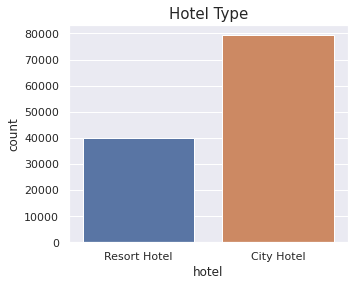

In [ ]:
# Plot the countplot for both the hotel types
sns.set(style = "darkgrid")
plt.figure(figsize=(5,4))
plt.title('Hotel Type', fontdict = {'fontsize': 15})
sns.countplot(data=hotel_booking_data, x = 'hotel')
plt.show()

In [ ]:
# Plotting a pie-chart to visualise the number of records by country

'''
This analysis involves 3 parts:
1. Visualising the number of bookings by country.
2. Visualising the number of confirmed(non-cancelled) bookings by country.
3. Visualising the number of cancelled bookings by country.
'''


# Extract the total country data
total_country_data =  hotel_booking_data['country'].value_counts().to_frame().reset_index()
total_country_data.rename(columns = {'index' : 'country', 'country' : 'guest_count'}, inplace=True)

# Extract the total country data with confirmed bookings
total_country_data_confirmed =  hotel_booking_data[hotel_booking_data['is_canceled'] == 0]['country'].value_counts().to_frame().reset_index()
total_country_data_confirmed.rename(columns = {'index' : 'country', 'country' : 'guest_count_confirmed'}, inplace=True)

# Extract the total country data with canceled bookings
total_country_data_canceled =  hotel_booking_data[hotel_booking_data['is_canceled'] == 1]['country'].value_counts().to_frame().reset_index()
total_country_data_canceled.rename(columns = {'index' : 'country', 'country' : 'guest_count_canceled'}, inplace=True)


#################################################################### PLOT THE PIE CHARTS ##########################################################################################

fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])

# 1 Visualising the number of bookings by country
fig.add_trace(go.Pie(labels = total_country_data['country'].values.tolist(), 
                     values=total_country_data['guest_count'].values.tolist(), 
                     title = 'Total Bookings Across Countries'), 1, 1)

# 2. Visualising the number of confirmed(non-cancelled) bookings by country
fig.add_trace(go.Pie(labels = total_country_data_confirmed['country'].values.tolist(), 
                     values=total_country_data_confirmed['guest_count_confirmed'].values.tolist(), 
                     title = 'Total Confirmed Bookings Across Countries'), 1, 2)

# 3. Visualising the number of cancelled bookings by country
fig.add_trace(go.Pie(labels = total_country_data_canceled['country'].values.tolist(), 
                    values=total_country_data_canceled['guest_count_canceled'].values.tolist(), 
                    title = 'Total Canceled Bookings Across Countries'), 1, 3)
# Update the traces
fig.update_traces(textposition="inside", textinfo="label+percent+value",textfont_size=12,
                  marker=dict(line=dict(color='black', width=0.5)))

In [ ]:
# Display the total bookings (including confirmed and canceled) across countries on the World Map

# Calculate the percentage of bookings across countries
total_country_data['%_guest_across_countries'] = np.round(total_country_data['guest_count']*100/total_country_data['guest_count'].sum(), 2)

# Plot the map
bookings_map = px.choropleth(total_country_data,
                             locations=total_country_data['country'],
                             color=total_country_data["%_guest_across_countries"], 
                             hover_name=total_country_data["country"], 
                             color_continuous_scale=px.colors.sequential.Plasma,
                             title="Total Bookings Across Countries")
bookings_map.show()

In [ ]:
hotel_booking_data['arrival_date_month'].value_counts()

August       3840
July         3535
September    3108
October      3089
April        2494
May          2418
March        2276
June         2063
February     2020
December     1710
November     1491
January      1220
Name: arrival_date_month, dtype: int64

In [ ]:
# Create a feature called arrival data

#--> Map the name of the months with their corresponding numbers
def map_months(x):

  if x == 'January':
    x = 1
  elif x == 'February':
    x = 2
  elif x == 'March':
    x = 3
  elif x == 'April':
    x = 4
  elif x == 'May':
    x = 5
  elif x == 'June':
    x = 6
  elif x == 'July':
    x = 7
  elif x == 'August':
    x = 8
  elif x == 'September':
    x = 9
  elif x == 'October':
    x = 10
  elif x == 'November':
    x = 11
  elif x == 'December':
    x = 12
  return x

# Use the above mapping to create a new feature
hotel_booking_data['arrival_date_month_number'] = hotel_booking_data['arrival_date_month'].apply(lambda x : map_months(x))
hotel_booking_data['arrival_date'] = hotel_booking_data['arrival_date_day_of_month'].astype('str') + '/' + hotel_booking_data['arrival_date_month_number'].astype('str') + '/'+ hotel_booking_data['arrival_date_year'].astype('str')

In [ ]:
# Convert into datetime variable
hotel_booking_data['arrival_date'] = pd.to_datetime(hotel_booking_data['arrival_date'])

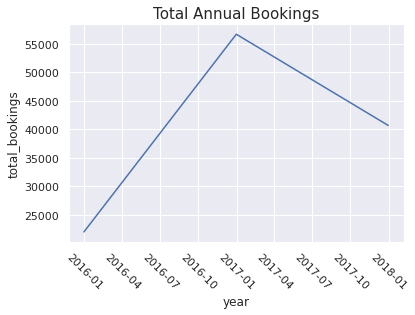

In [ ]:
# Extract the total number of bookings for both the hotel types
bookings_by_date = hotel_booking_data['arrival_date'].value_counts().to_frame()
bookings_per_year = bookings_by_date.resample('y').sum().reset_index().rename(columns = {'index' : 'year', 'arrival_date': 'total_bookings'})

# Plot a line chart to visualise the total annual bookings
sns.lineplot(data = bookings_per_year, x = 'year', y = 'total_bookings')
plt.xticks(rotation = -45)
plt.title('Total Annual Bookings', fontdict = {'fontsize' : 15})
plt.show()

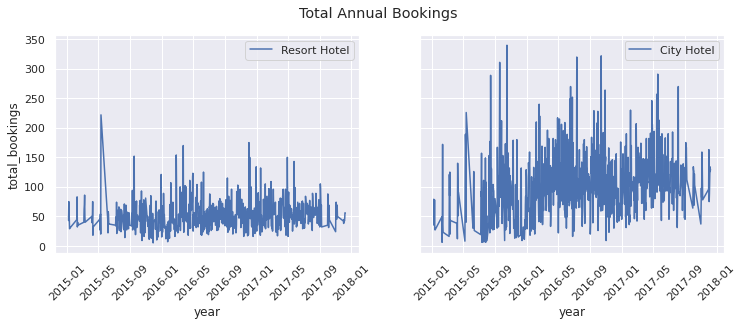

In [ ]:
# Extract the resort and city hotel data
hotel_resort_data = hotel_booking_data[hotel_booking_data['hotel'] == 'Resort Hotel']
hotel_city_data = hotel_booking_data[hotel_booking_data['hotel'] == 'City Hotel']

# Extract the total annual bookings from both the frames

# 1. Resort Hotel
total_annual_bookings_resort = hotel_resort_data['arrival_date'].value_counts().to_frame().reset_index()
total_annual_bookings_resort.rename(columns = {'index' : 'year', 'arrival_date': 'total_bookings'}, inplace=True)

# 2. City Hotel
total_annual_bookings_city = hotel_city_data['arrival_date'].value_counts().to_frame().reset_index()
total_annual_bookings_city.rename(columns = {'index' : 'year', 'arrival_date': 'total_bookings'}, inplace=True)


# Plot the line chart
sns.set(style='darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
sns.lineplot(data = total_annual_bookings_resort, x = 'year', y = 'total_bookings', label='Resort Hotel', ax=ax1)
sns.lineplot(data = total_annual_bookings_city, x = 'year', y = 'total_bookings', label='City Hotel', ax=ax2)
ax1.tick_params(labelrotation=45, axis='x')
ax2.tick_params(labelrotation=45, axis='x')
plt.suptitle('Total Annual Bookings')
fig.show()

In [ ]:
# Extract the monthly bookings for both the hotesl

# 1. Resort Hotel
total_monthly_bookings_resort = hotel_resort_data['arrival_date'].value_counts()
total_monthly_bookings_resort = total_monthly_bookings_resort.resample('m').sum().to_frame().reset_index()
total_monthly_bookings_resort.rename(columns = {'index' : 'months', 'arrival_date':'total_bookings'}, inplace=True)

# 2. City Hotel
total_monthly_bookings_city = hotel_city_data['arrival_date'].value_counts()
total_monthly_bookings_city = total_monthly_bookings_city.resample('m').sum().to_frame().reset_index()
total_monthly_bookings_city.rename(columns = {'index' : 'months', 'arrival_date':'total_bookings'}, inplace=True)

# Plot the line charts
fig = go.Figure()

fig.add_trace(go.Scatter(x=total_monthly_bookings_resort['months'], y=total_monthly_bookings_resort['total_bookings'], name="Resort Hotel"))
fig.add_trace(go.Scatter(x=total_monthly_bookings_city['months'], y=total_monthly_bookings_city['total_bookings'], name="City Hotel"))
fig.update_layout(title_text='Total Monthly Bookings', title_x=0.5, title_font=dict(size=20))  # Location and the font size of the main title
fig.update_layout(xaxis_title="Arrival Date",yaxis_title="Total Bookings")

fig.show()

In [ ]:
# Extract the daily bookings for both the hotesl

# 1. Resort Hotel
total_daily_bookings_resort = hotel_resort_data['arrival_date'].value_counts()
total_daily_bookings_resort = total_daily_bookings_resort.resample('d').sum().to_frame().reset_index()
total_daily_bookings_resort.rename(columns = {'index' : 'days', 'arrival_date':'total_bookings'}, inplace=True)

# 2. City Hotel
total_daily_bookings_city = hotel_city_data['arrival_date'].value_counts()
total_daily_bookings_city = total_daily_bookings_city.resample('d').sum().to_frame().reset_index()
total_daily_bookings_city.rename(columns = {'index' : 'days', 'arrival_date':'total_bookings'}, inplace=True)

# Plot the line charts
fig = go.Figure()

fig.add_trace(go.Scatter(x=total_daily_bookings_resort['days'], y=total_daily_bookings_resort['total_bookings'], name="Resort Hotel"))
fig.add_trace(go.Scatter(x=total_daily_bookings_city['days'], y=total_daily_bookings_city['total_bookings'], name="City Hotel"))
fig.update_layout(title_text='Total Daily Bookings', title_x=0.5, title_font=dict(size=20))  # Location and the font size of the main title
fig.update_layout(xaxis_title="Arrival Date",yaxis_title="Total Bookings")

fig.show()

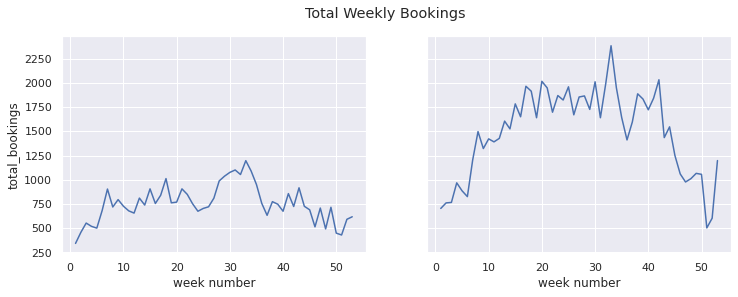

In [ ]:
# Extract the weekly bookings for both the hotels

# 1. Resort Hotel
total_weekly_bookings_resort = hotel_resort_data['arrival_date_week_number'].value_counts().to_frame().reset_index()
total_weekly_bookings_resort.rename(columns = {'index':'week number', 'arrival_date_week_number' : 'total_bookings'}, inplace=True)

# 2. City Hotel
total_weekly_bookings_city = hotel_city_data['arrival_date_week_number'].value_counts().to_frame().reset_index()
total_weekly_bookings_city.rename(columns = {'index':'week number', 'arrival_date_week_number' : 'total_bookings'}, inplace=True)

# Plot the line charts
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,4))
sns.lineplot(data = total_weekly_bookings_resort, x = 'week number', y = 'total_bookings', ax = ax[0])
sns.lineplot(data = total_weekly_bookings_city, x = 'week number', y = 'total_bookings', ax = ax[1])
plt.suptitle('Total Weekly Bookings')
plt.show()

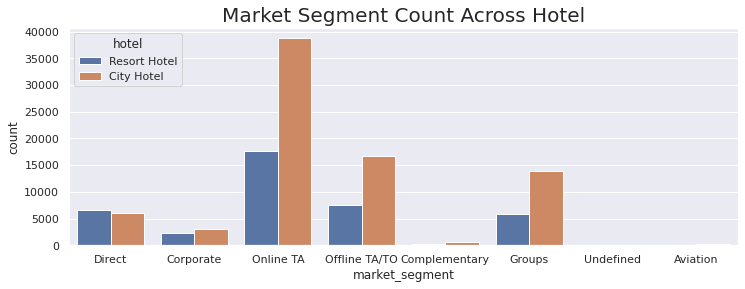

In [ ]:
# 1. Visualise the count of each marget segment across both the hotel types
plt.figure(figsize=(12, 4))
sns.countplot(data=hotel_booking_data, x = 'market_segment', hue='hotel')
plt.title('Market Segment Count Across Hotel', fontdict={'fontsize' : 20})
plt.show()

In [ ]:
# Extract the data for every market segment for both city and the resort hotel

mark_seg_direct = hotel_booking_data[hotel_booking_data['market_segment'] == 'Direct']['arrival_date'].value_counts().resample('m').sum().to_frame()
mark_seg_online = hotel_booking_data[hotel_booking_data['market_segment'] == 'Online TA ']['arrival_date'].value_counts().resample('m').sum().to_frame()
mark_seg_offline = hotel_booking_data[hotel_booking_data['market_segment'] == 'Offline TA/TO']['arrival_date'].value_counts().resample('m').sum().to_frame()
mark_seg_groups = hotel_booking_data[hotel_booking_data['market_segment'] == 'Groups']['arrival_date'].value_counts().resample('m').sum().to_frame()
mark_seg_corporate = hotel_booking_data[hotel_booking_data['market_segment'] == 'Corporate']['arrival_date'].value_counts().resample('m').sum().to_frame()
mark_seg_complementary = hotel_booking_data[hotel_booking_data['market_segment'] == 'Complementary']['arrival_date'].value_counts().resample('m').sum().to_frame()
mark_seg_aviation = hotel_booking_data[hotel_booking_data['market_segment'] == 'Aviation']['arrival_date'].value_counts().resample('m').sum().to_frame()


################################################################### SUBPLOT ACROSS MARKET SEGMENT ##################################################################################

fig = go.Figure()
fig.add_trace(go.Scatter(x=mark_seg_direct.index, y=mark_seg_direct['arrival_date'], name="Direct"))
fig.add_trace(go.Scatter(x=mark_seg_online.index, y=mark_seg_online['arrival_date'], name="Online TA"))
fig.add_trace(go.Scatter(x=mark_seg_offline.index, y=mark_seg_offline['arrival_date'], name="Offline TA/TO"))
fig.add_trace(go.Scatter(x=mark_seg_groups.index, y=mark_seg_groups['arrival_date'], name="Groups"))
fig.add_trace(go.Scatter(x=mark_seg_corporate.index, y=mark_seg_corporate['arrival_date'], name="Corporate"))
fig.add_trace(go.Scatter(x=mark_seg_complementary.index, y=mark_seg_complementary['arrival_date'], name="Complementary"))
fig.add_trace(go.Scatter(x=mark_seg_aviation.index, y=mark_seg_aviation['arrival_date'], name="Aviation"))
fig.update_layout(title_text='Total Monthly Bookings Across Market Segments', title_x=0.5, title_font=dict(size=20))  
fig.update_layout(xaxis_title="Arrival Date",yaxis_title="Total Bookings")
fig.show()

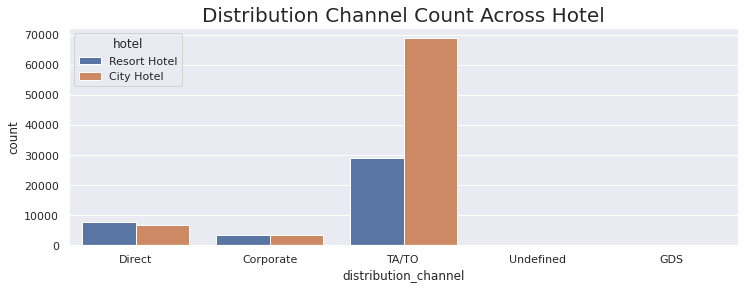

In [ ]:
# Visualise the distribution channel count across hotel
plt.figure(figsize=(12, 4))
sns.countplot(data=hotel_booking_data, x = 'distribution_channel', hue='hotel')
plt.title('Distribution Channel Count Across Hotel', fontdict={'fontsize' : 20})
plt.show()

In [ ]:
# Extract the data for every distribution channel for both city and the resort hotel

distibution_channel_ta_to = hotel_booking_data[hotel_booking_data['distribution_channel'] == 'TA/TO']['arrival_date'].value_counts().resample('m').sum().to_frame()
distibution_channel_direct = hotel_booking_data[hotel_booking_data['distribution_channel'] == 'Direct']['arrival_date'].value_counts().resample('m').sum().to_frame()
distibution_channel_corporate = hotel_booking_data[hotel_booking_data['distribution_channel'] == 'Corporate']['arrival_date'].value_counts().resample('m').sum().to_frame()
distibution_channel_gds = hotel_booking_data[hotel_booking_data['distribution_channel'] == 'GDS']['arrival_date'].value_counts().resample('m').sum().to_frame()
distibution_channel_undefined = hotel_booking_data[hotel_booking_data['distribution_channel'] == 'Undefined']['arrival_date'].value_counts().resample('m').sum().to_frame()

################################################################### SUBPLOT ACROSS Distribution Channel ##################################################################################

fig = go.Figure()
fig.add_trace(go.Scatter(x=distibution_channel_ta_to.index, y=distibution_channel_ta_to['arrival_date'], name="TA/TO"))
fig.add_trace(go.Scatter(x=distibution_channel_direct.index, y=distibution_channel_direct['arrival_date'], name="Direct"))
fig.add_trace(go.Scatter(x=distibution_channel_corporate.index, y=distibution_channel_corporate['arrival_date'], name="Corporate"))
fig.add_trace(go.Scatter(x=distibution_channel_gds.index, y=distibution_channel_gds['arrival_date'], name="GDS"))
fig.add_trace(go.Scatter(x=distibution_channel_gds.index, y=distibution_channel_gds['arrival_date'], name="Undefined"))
fig.update_layout(title_text='Total Monthly Bookings Across Distribution Channel', title_x=0.5, title_font=dict(size=20))  
fig.update_layout(xaxis_title="Arrival Date",yaxis_title="Total Bookings")
fig.show()

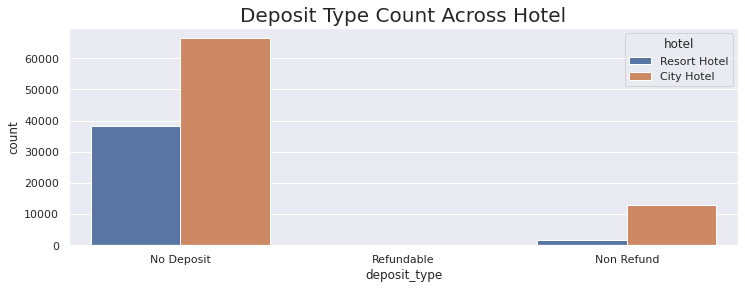

In [ ]:
# 1. Visualise the deposit_type across hotel 
plt.figure(figsize=(12, 4))
sns.countplot(data=hotel_booking_data, x = 'deposit_type', hue='hotel')
plt.title('Deposit Type Count Across Hotel', fontdict={'fontsize' : 20})
plt.show()

In [ ]:
# Extract the data for every distribution channel for both city and the resort hotel

deposit_type_no_deposit = hotel_booking_data[hotel_booking_data['deposit_type'] == 'No Deposit']['arrival_date'].value_counts().resample('m').sum().to_frame()
deposit_type_non_refund = hotel_booking_data[hotel_booking_data['deposit_type'] == 'Non Refund']['arrival_date'].value_counts().resample('m').sum().to_frame()
deposit_type_refundable = hotel_booking_data[hotel_booking_data['deposit_type'] == 'Refundable']['arrival_date'].value_counts().resample('m').sum().to_frame()

################################################################### SUBPLOT ACROSS DEPOSIT TYPE ##################################################################################

fig = go.Figure()
fig.add_trace(go.Scatter(x=deposit_type_no_deposit.index, y=deposit_type_no_deposit['arrival_date'], name="No Deposit"))
fig.add_trace(go.Scatter(x=deposit_type_non_refund.index, y=deposit_type_non_refund['arrival_date'], name="Non Refund"))
fig.add_trace(go.Scatter(x=deposit_type_refundable.index, y=deposit_type_refundable['arrival_date'], name="Refundable"))
fig.update_layout(title_text='Total Monthly Bookings Across Deposit Type', title_x=0.5, title_font=dict(size=20))  
fig.update_layout(xaxis_title="Arrival Date",yaxis_title="Total Bookings")
fig.show()



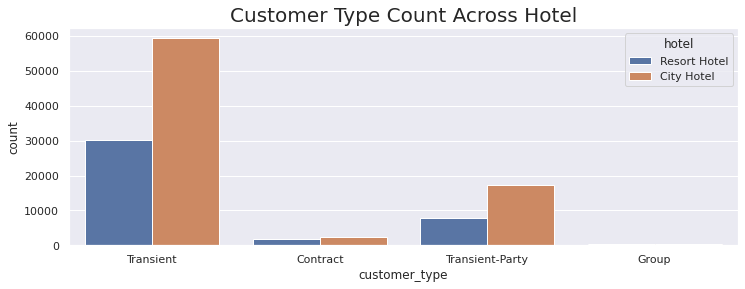

In [ ]:
# 1. Visualise the cutomer type across hotel 
plt.figure(figsize=(12, 4))
sns.countplot(data=hotel_booking_data, x = 'customer_type', hue='hotel')
plt.title('Customer Type Count Across Hotel', fontdict={'fontsize' : 20})
plt.show()

In [ ]:
# Extract the data for every Customer Type for both city and the resort hotel

cutomer_type_transient = hotel_booking_data[hotel_booking_data['customer_type'] == 'Transient']['arrival_date'].value_counts().resample('m').sum().to_frame()
customer_type_transient_party = hotel_booking_data[hotel_booking_data['customer_type'] == 'Transient-Party']['arrival_date'].value_counts().resample('m').sum().to_frame()
customer_type_contract = hotel_booking_data[hotel_booking_data['customer_type'] == 'Contract']['arrival_date'].value_counts().resample('m').sum().to_frame()

################################################################### SUBPLOT ACROSS DEPOSIT TYPE ##################################################################################

fig = go.Figure()
fig.add_trace(go.Scatter(x=cutomer_type_transient.index, y=cutomer_type_transient['arrival_date'], name="Transient"))
fig.add_trace(go.Scatter(x=customer_type_transient_party.index, y=customer_type_transient_party['arrival_date'], name="Transient-Party"))
fig.add_trace(go.Scatter(x=customer_type_contract.index, y=customer_type_contract['arrival_date'], name="Contract"))
fig.update_layout(title_text='Total Monthly Bookings Across Customer Type', title_x=0.5, title_font=dict(size=20))  
fig.update_layout(xaxis_title="Arrival Date",yaxis_title="Total Bookings")
fig.show()

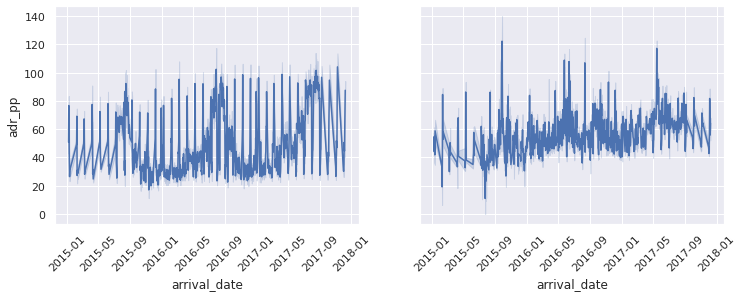

In [ ]:
# Average Daily Rate per person across both the hotel types
hotel_resort_data['adr_pp'] = hotel_resort_data['adr']/(hotel_resort_data['adults'] + hotel_resort_data['children'] + hotel_resort_data['babies'])
hotel_city_data['adr_pp'] = hotel_city_data['adr']/(hotel_city_data['adults'] + hotel_city_data['children'] + hotel_city_data['babies'])

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,4))
sns.lineplot(data=hotel_resort_data, x = 'arrival_date', y = 'adr_pp', ax = ax[0])
sns.lineplot(data=hotel_city_data, x = 'arrival_date', y = 'adr_pp', ax = ax[1])
ax[0].tick_params(labelrotation=45, axis='x')
ax[1].tick_params(labelrotation=45, axis='x')
fig.show()


In [ ]:
hotel_booking_data['adr_pp'] = hotel_booking_data['adr']/(hotel_booking_data['adults'] + hotel_booking_data['children'] + hotel_booking_data['babies'])

In [ ]:
# Calcualte the average and maximum ADR across City Hotel
avg_adr_city = hotel_city_data['adr'].mean()
max_adr_city = hotel_city_data['adr'].max()

# Calcualte the average and maximum ADR across Resort Hotel
avg_adr_resort = hotel_resort_data['adr'].mean()
max_adr_resort = hotel_resort_data['adr'].max()

In [ ]:
print("Mean ADR for City Hotel is {:.2f}".format(avg_adr_city))
print("Mean ADR for Resort Hotel is {:.2f}".format(avg_adr_resort))

print("Max ADR for City Hotel is {}".format(max_adr_city))
print("Max ADR for Resort Hotel is {}".format(max_adr_resort))

Mean ADR for City Hotel is 105.30
Mean ADR for Resort Hotel is 94.95
Max ADR for City Hotel is 5400.0
Max ADR for Resort Hotel is 508.0


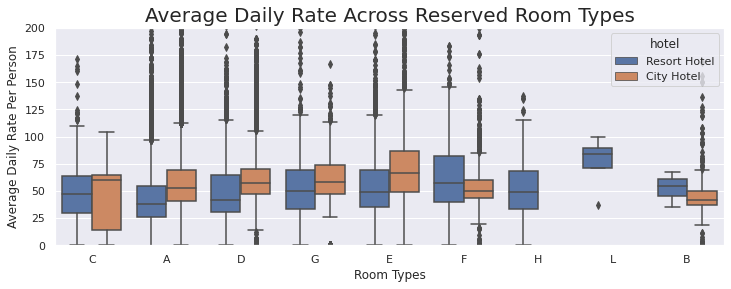

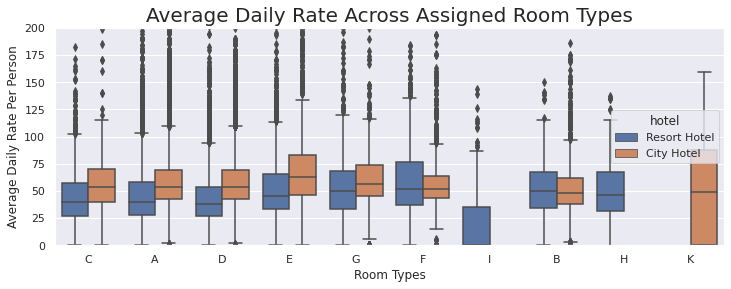

In [ ]:
# visualising adr_pp across reserved room type
plt.figure(figsize=(12,4))
sns.boxplot(data=hotel_booking_data[hotel_booking_data['is_canceled'] == 0], x = 'reserved_room_type', y = 'adr_pp', hue = 'hotel') # Note: Here considering only confirmed bookings
plt.title("Average Daily Rate Across Reserved Room Types", fontdict = {'fontsize' : 20})
plt.xlabel('Room Types')
plt.ylabel('Average Daily Rate Per Person')
plt.ylim(0,200)
plt.show()

# visualising adr_pp across assigned room type
plt.figure(figsize=(12,4))
sns.boxplot(data=hotel_booking_data[hotel_booking_data['is_canceled'] == 0], x = 'assigned_room_type', y = 'adr_pp', hue = 'hotel') # Note: Here considering only confirmed bookings
plt.title("Average Daily Rate Across Assigned Room Types", fontdict = {'fontsize' : 20})
plt.xlabel('Room Types')
plt.ylabel('Average Daily Rate Per Person')
plt.ylim(0,200)
plt.show()

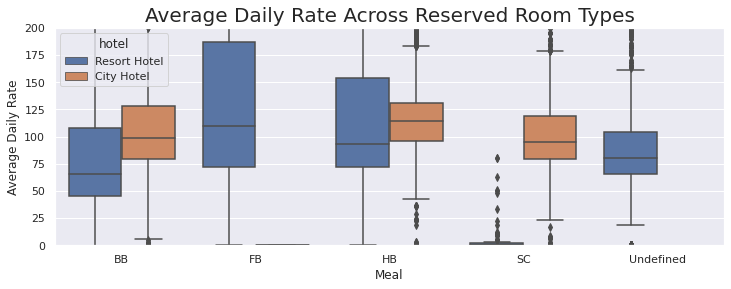

In [ ]:
# visualising adr_pp across meal
plt.figure(figsize=(12,4))
sns.boxplot(data=hotel_booking_data[hotel_booking_data['is_canceled'] == 0], x = 'meal', y = 'adr', hue = 'hotel') # Note: Here considering only confirmed bookings
plt.title("Average Daily Rate Across Reserved Room Types", fontdict = {'fontsize' : 20})
plt.xlabel('Meal')
plt.ylabel('Average Daily Rate')
plt.ylim(0,200)
plt.show()

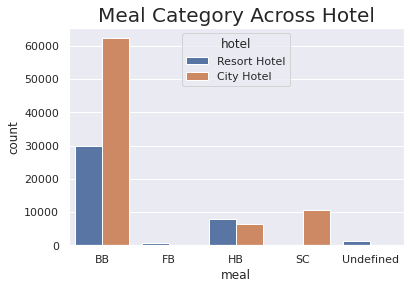

In [ ]:
sns.countplot(data = hotel_booking_data, x = 'meal', hue='hotel')
plt.title('Meal Category Across Hotel', fontdict={'fontsize' : 20})
plt.show()

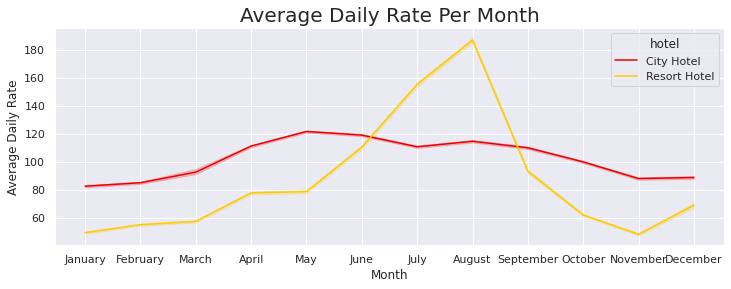

In [ ]:
# Extract the monthly adr data
adr_monthly = hotel_booking_data[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

# Order the data by months
ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
adr_monthly["arrival_date_month"] = pd.Categorical(adr_monthly["arrival_date_month"], categories=ordered_months, ordered=True)

############################################################ PLOT THE VARIATION OF ADR ACROSS MONTHS ######################################################

# Plot ADR versus Months
plt.figure(figsize=(12,4))
sns.lineplot(data=adr_monthly , x='arrival_date_month', y='adr', hue='hotel', palette='hot')
plt.title('Average Daily Rate Per Month', fontdict={'fontsize' : 20})
plt.xlabel('Month')
plt.ylabel('Average Daily Rate')
plt.show()

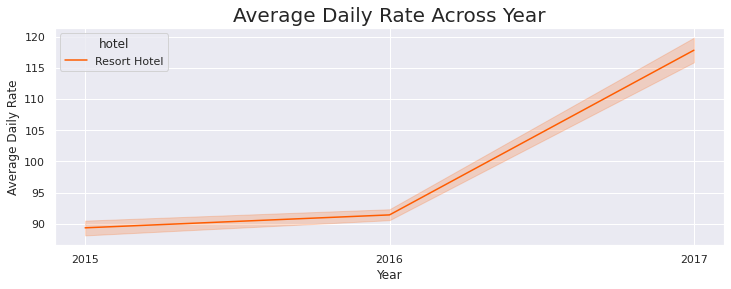

In [ ]:
# Variation of ADR annually
plt.figure(figsize=(12,4))
sns.lineplot(data=hotel_booking_data , x='arrival_date_year', y='adr', hue='hotel', palette='hot')
plt.title('Average Daily Rate Across Year', fontdict={'fontsize' : 20})
plt.xlabel('Year')
plt.ylabel('Average Daily Rate')
plt.xticks(np.arange(2015, 2018, 1))
plt.show()

In [ ]:
 # Display the Maximum and Mean ADR for both the hotels for all the three years


# 1. City Hotel
for year in list((2015, 2016, 2017)):

  # Calculate the Max and Mean ADR for a particular year
  max_adr = hotel_city_data[hotel_city_data['arrival_date_year'] == year]['adr'].max()
  mean_adr = hotel_city_data[hotel_city_data['arrival_date_year'] == year]['adr'].mean()

  print("Maximum ADR for City Hotel in the year {} is {}".format(year, max_adr))
  print("Mean ADR for City Hotel in the year {} is {:.2f}".format(year, mean_adr))

# 2. Resort Hotel
for year in list((2015, 2016, 2017)):

  max_adr = hotel_resort_data[hotel_resort_data['arrival_date_year'] == year]['adr'].max()
  mean_adr = hotel_resort_data[hotel_resort_data['arrival_date_year'] == year]['adr'].mean()

  print("Maximum ADR for Resort Hotel in the year {} is {}".format(year, max_adr))
  print("Mean ADR for Resort Hotel in the year {} is {:.2f}".format(year, mean_adr))

Maximum ADR for City Hotel in the year 2015 is 290.0
Mean ADR for City Hotel in the year 2015 is 85.86
Maximum ADR for City Hotel in the year 2016 is 5400.0
Mean ADR for City Hotel in the year 2016 is 103.48
Maximum ADR for City Hotel in the year 2017 is 510.0
Mean ADR for City Hotel in the year 2017 is 117.50
Maximum ADR for Resort Hotel in the year 2015 is 508.0
Mean ADR for Resort Hotel in the year 2015 is 89.35
Maximum ADR for Resort Hotel in the year 2016 is 384.0
Mean ADR for Resort Hotel in the year 2016 is 87.73
Maximum ADR for Resort Hotel in the year 2017 is 450.0
Mean ADR for Resort Hotel in the year 2017 is 108.66


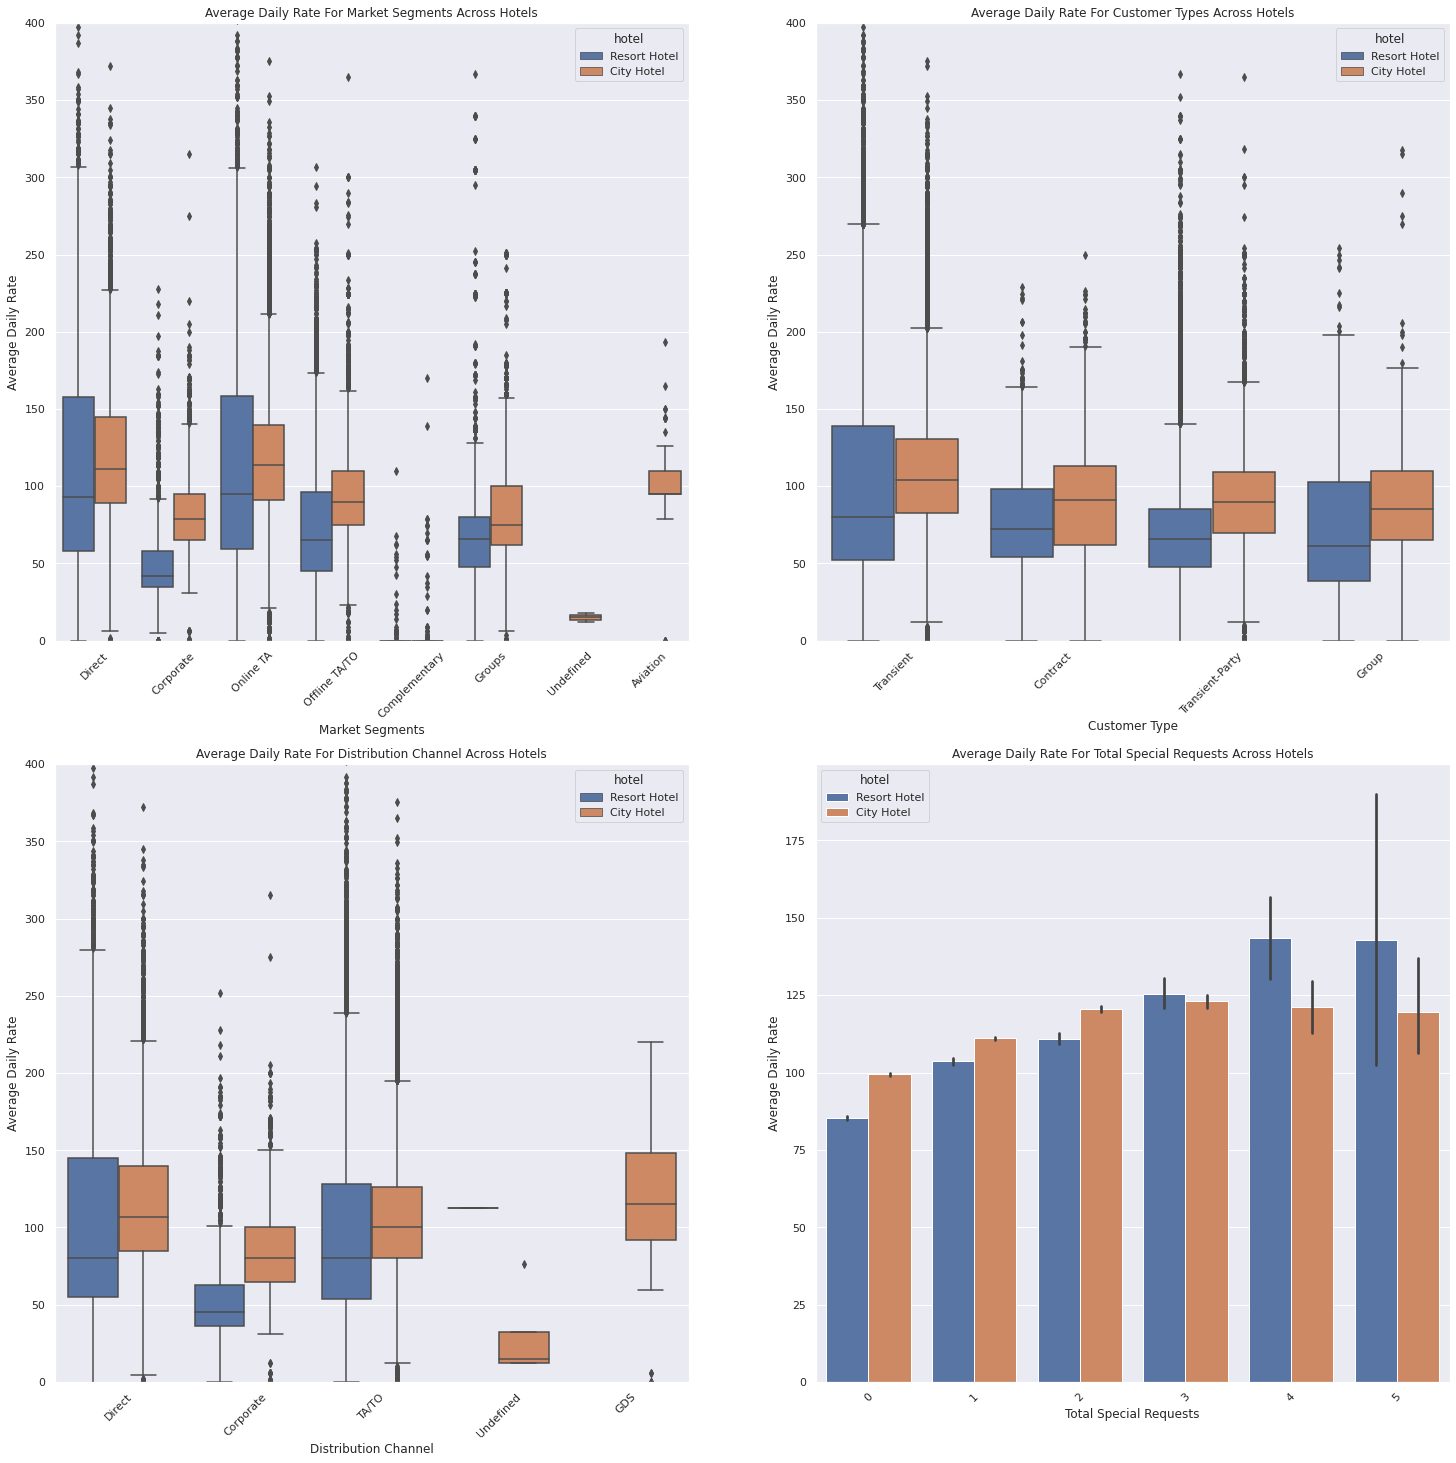

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,25))

# 1. Variation of ADR across market segments for both the hotels
sns.boxplot(data=hotel_booking_data, x='market_segment', y='adr', hue='hotel', ax=ax[0][0])
ax[0][0].set_xlabel('Market Segments')
ax[0][0].set_ylabel('Average Daily Rate')
ax[0][0].set_title('Average Daily Rate For Market Segments Across Hotels')
ax[0][0].set_ylim(0,400)
ax[0][0].tick_params(labelrotation=45, axis='x')

# 2. Variation of ADR across customer type for both the hotels
sns.boxplot(data=hotel_booking_data, x='customer_type', y='adr', hue='hotel', ax=ax[0][1])
ax[0][1].set_xlabel('Customer Type')
ax[0][1].set_ylabel('Average Daily Rate')
ax[0][1].set_title('Average Daily Rate For Customer Types Across Hotels')
ax[0][1].set_ylim(0,400)
ax[0][1].tick_params(labelrotation=45, axis='x')

# 3. Variation of ADR across distribution channel for both the hotels
sns.boxplot(data=hotel_booking_data, x='distribution_channel', y='adr', hue='hotel', ax=ax[1][0])
ax[1][0].set_xlabel('Distribution Channel')
ax[1][0].set_ylabel('Average Daily Rate')
ax[1][0].set_title('Average Daily Rate For Distribution Channel Across Hotels')
ax[1][0].set_ylim(0,400)
ax[1][0].tick_params(labelrotation=45, axis='x')

# 4. Variation of ADR across number of special requests for both the hotels
sns.barplot(data=hotel_booking_data, x='total_of_special_requests', y='adr', hue='hotel', ax=ax[1][1])
ax[1][1].set_xlabel('Total Special Requests')
ax[1][1].set_ylabel('Average Daily Rate')
ax[1][1].set_title('Average Daily Rate For Total Special Requests Across Hotels')
ax[1][1].tick_params(labelrotation=45, axis='x')

fig.show()

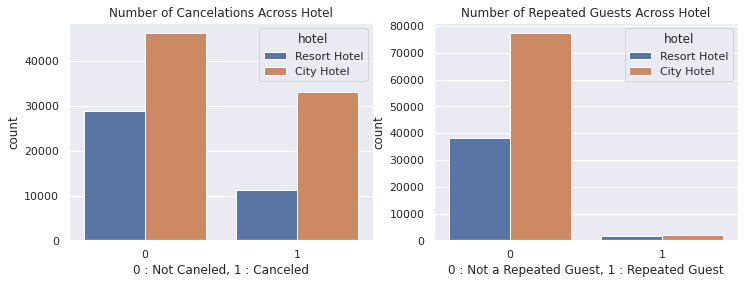

In [ ]:
# Some important statistics

# Checking count of canceled bookings across hotels and count of repeated guests across both the hotels
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.countplot(data=hotel_booking_data, x='is_canceled', hue='hotel', ax=ax[0])
ax[0].set_title('Number of Cancelations Across Hotel')
ax[0].set_xlabel('0 : Not Caneled, 1 : Canceled')
sns.countplot(data=hotel_booking_data, x='is_repeated_guest', hue='hotel', ax=ax[1])
ax[1].set_title('Number of Repeated Guests Across Hotel')
ax[1].set_xlabel('0 : Not a Repeated Guest, 1 : Repeated Guest')

fig.show()

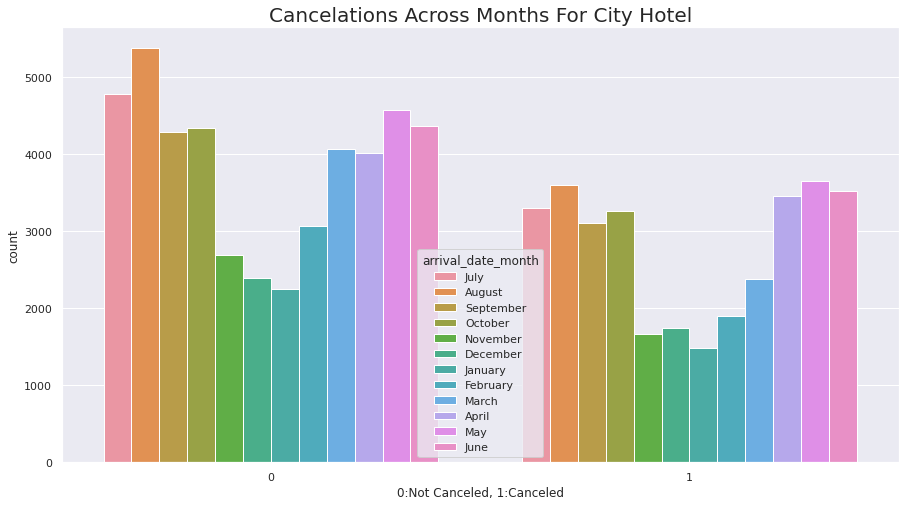

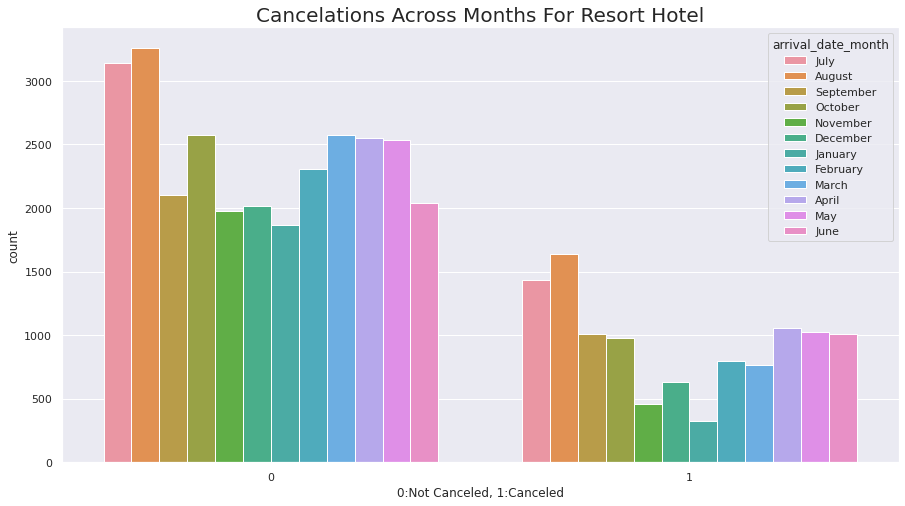

In [ ]:
# Cancelation across months for City Hotel
plt.figure(figsize=(15,8))
sns.countplot(data=hotel_city_data, x='is_canceled', hue='arrival_date_month')
plt.xlabel('0:Not Canceled, 1:Canceled')
plt.title("Cancelations Across Months For City Hotel", fontdict={'fontsize':20})
plt.show()

# Cancelation across months for City Hotel
plt.figure(figsize=(15,8))
sns.countplot(data=hotel_resort_data, x='is_canceled', hue='arrival_date_month')
plt.xlabel('0:Not Canceled, 1:Canceled')
plt.title("Cancelations Across Months For Resort Hotel", fontdict={'fontsize':20})
plt.show()

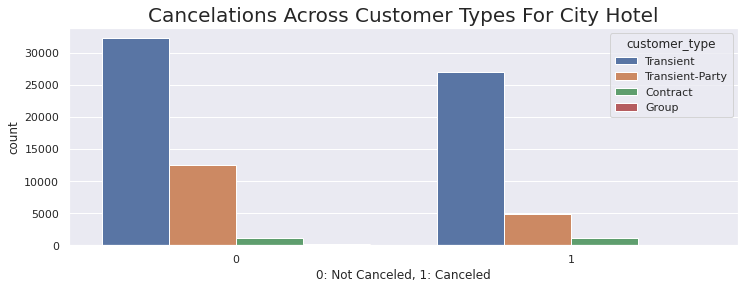

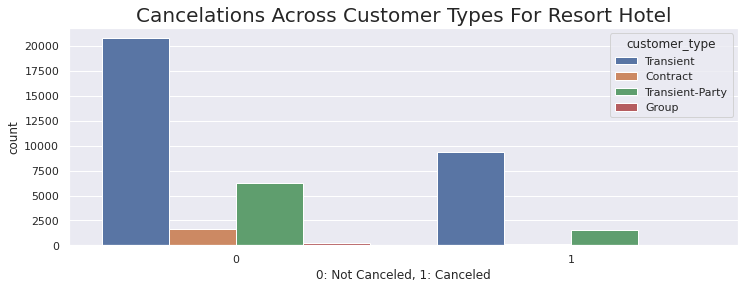

In [ ]:
# Cancelation across city hotel for each customer type
plt.figure(figsize=(12,4))
sns.countplot(data=hotel_city_data, x='is_canceled', hue='customer_type')
plt.title('Cancelations Across Customer Types For City Hotel', fontdict={'fontsize':20})
plt.xlabel('0: Not Canceled, 1: Canceled')
plt.show()

# Cancelation across resort hotel for each customer type
plt.figure(figsize=(12,4))
sns.countplot(data=hotel_resort_data, x='is_canceled', hue='customer_type')
plt.title('Cancelations Across Customer Types For Resort Hotel', fontdict={'fontsize':20})
plt.xlabel('0: Not Canceled, 1: Canceled')
plt.show()

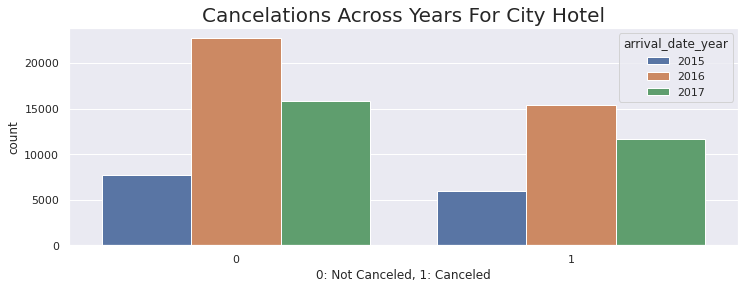

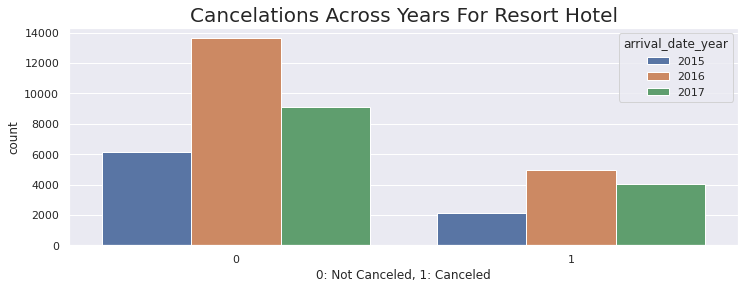

In [ ]:
# Cancelation across city hotel for every year
plt.figure(figsize=(12,4))
sns.countplot(data=hotel_city_data, x='is_canceled', hue='arrival_date_year')
plt.title('Cancelations Across Years For City Hotel', fontdict={'fontsize':20})
plt.xlabel('0: Not Canceled, 1: Canceled')
plt.show()

# Cancelation across resort hotel for every year
plt.figure(figsize=(12,4))
sns.countplot(data=hotel_resort_data, x='is_canceled', hue='arrival_date_year')
plt.title('Cancelations Across Years For Resort Hotel', fontdict={'fontsize':20})
plt.xlabel('0: Not Canceled, 1: Canceled')
plt.show()

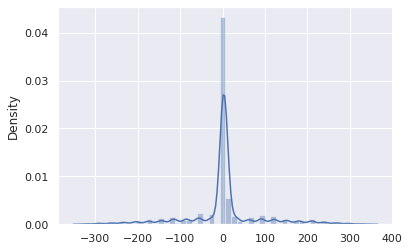

In [ ]:
# Distribution of number of days of stay

# Extract the data for only those customers who did actually come
hotel_booking_data_confirmed = hotel_booking_data[hotel_booking_data['reservation_status'] == 'Check-Out'][['reservation_status_date', 'arrival_date']]
total_days_of_stay = pd.to_datetime(hotel_booking_data_confirmed['reservation_status_date']) - hotel_booking_data_confirmed['arrival_date']
sns.distplot(total_days_of_stay.dt.days)
plt.show()

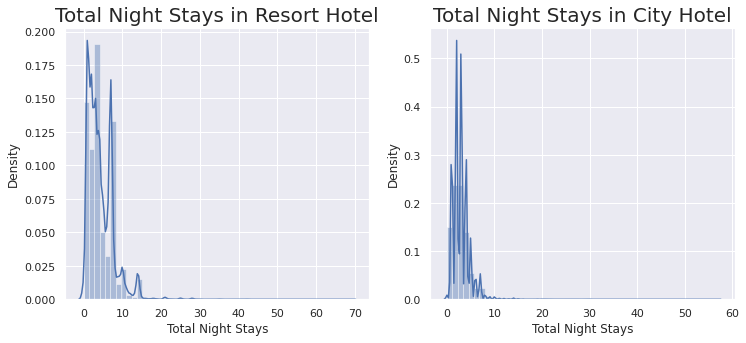

In [ ]:
# Another way to analyse the stay duration is by visualising the stays_in_nights column across both the hotels
hotel_booking_data['total_night_stays'] = hotel_booking_data['stays_in_week_nights'] + hotel_booking_data['stays_in_weekend_nights']
hotel_resort_data['total_night_stays'] = hotel_resort_data['stays_in_week_nights'] + hotel_resort_data['stays_in_weekend_nights']
hotel_city_data['total_night_stays'] = hotel_city_data['stays_in_week_nights'] + hotel_city_data['stays_in_weekend_nights']

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
# Distribution of total night stays across Resort Hotel
sns.distplot(hotel_resort_data['total_night_stays'], ax = ax[0])
ax[0].set_xlabel('Total Night Stays')
ax[0].set_title('Total Night Stays in Resort Hotel', fontdict={'fontsize' : 20})

# Distribution of total night stays across City Hotel
sns.distplot(hotel_city_data['total_night_stays'], ax = ax[1])
ax[1].set_xlabel('Total Night Stays')
ax[1].set_title('Total Night Stays in City Hotel', fontdict={'fontsize' : 20})

fig.show()

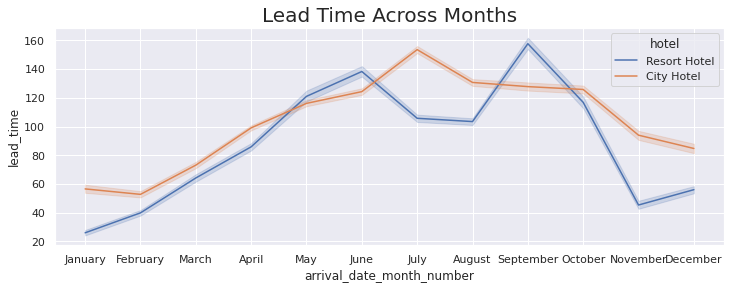

In [ ]:
# Next, I visualise the lead time for every month, since, from earlier observations that number of bookings increase during the summer months a similar pattern should be observed here as well.
labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ticks = np.arange(1,13)
plt.figure(figsize=(12,4))
sns.lineplot(data=hotel_booking_data, x='arrival_date_month_number', y='lead_time', hue='hotel')
plt.xticks(ticks=ticks, labels=labels)
plt.title("Lead Time Across Months", fontdict={'fontsize' : 20})
plt.show()

In [ ]:
# adr_pp has inf values hence, drop the column
hotel_booking_data.drop('adr_pp', axis=1, inplace=True)

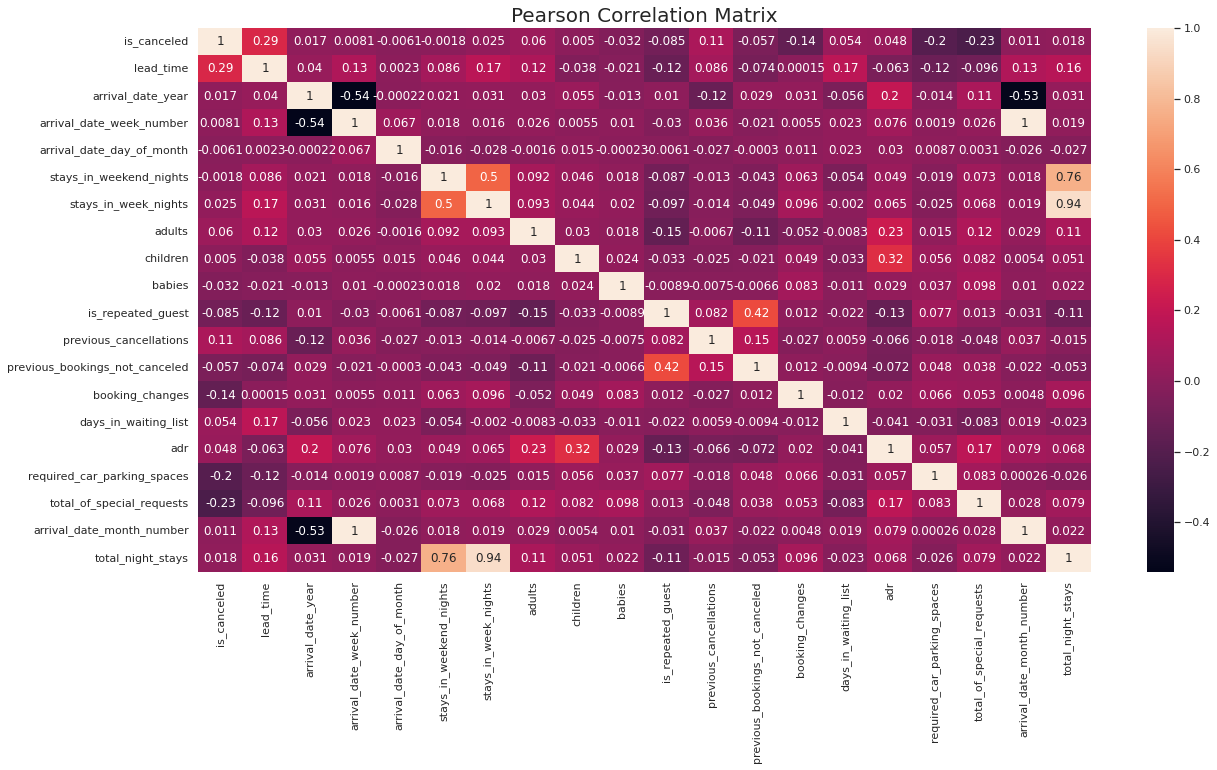

In [ ]:
# Plot the correlation heatmap
corr_matrix = hotel_booking_data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, linecolor='black', )
plt.title("Pearson Correlation Matrix", fontdict={'fontsize':20})
plt.show()

In [ ]:
# Enode the hotel column

'''
Resort Hotel --> 0
City Hotel --> 1
'''
map_hotel = {'Resort Hotel' : 0, 'City Hotel' : 1}
hotel_booking_data['hotel'] = hotel_booking_data['hotel'].map(map_hotel)

In [ ]:
# Drop the arrival_date_month because we have already encoded the same as arrival_date_month_number
hotel_booking_data.drop('arrival_date_month', axis=1, inplace=True)

In [ ]:
# convert the reservation_status_date into a float variable
def cnvt_date_to_num(x):
  return float(x.day*(10**6) + x.month*(10**4) + x.year)

# Apply the above function to both reservation_status_date and arrival_date
hotel_booking_data['reservation_status_date'] = pd.to_datetime(hotel_booking_data['reservation_status_date']).apply(lambda x : cnvt_date_to_num(x))
hotel_booking_data['arrival_date'] = hotel_booking_data['arrival_date'].apply(lambda x : cnvt_date_to_num(x))

In [ ]:
# Extract all the object type columns
object_columns = [cols for cols in hotel_booking_data.select_dtypes('object').columns]

# Check for columns with high cardinality
def check_high_cardnial_columns(data, columns, threshold = 20):

  high_cardinal_columns = [] # List for storing the columns for high cardinality

  # iterate over each object columns and check for cardinality
  for column in columns:
    cardinality = data[column].value_counts().shape[0]

    # Check if the cardinality is above the threshold
    if cardinality > threshold:
      high_cardinal_columns.append(column)

  return high_cardinal_columns

# Call the above function
high_cardinal_columns = check_high_cardnial_columns(hotel_booking_data, object_columns)

In [ ]:
high_cardinal_columns

['country', 'agent', 'company']

In [ ]:
# Encode the high cardinal column
for cols in high_cardinal_columns:
  # Creating a LabelEncoder object
  le = LabelEncoder()
  hotel_booking_data[cols] = hotel_booking_data[cols].astype('str')
  hotel_booking_data[cols] = le.fit_transform(hotel_booking_data[cols])

In [ ]:
# Remove the high cardinal columns from the object columns list
for cols in high_cardinal_columns:
  object_columns.remove(cols)

In [ ]:
# Create dummies for the rest of the object columns
final_data = pd.get_dummies(hotel_booking_data, drop_first=True)

In [ ]:
# Divide the data into features and target and then scale the features
X = final_data.drop('is_canceled', axis=1)
y = final_data['is_canceled']

# Scale the features
for col in X.columns:
  mms = MinMaxScaler()
  X[col] = mms.fit_transform(X[col].values.reshape(-1,1))

In [ ]:
from sklearn.feature_selection import RFE 

In [ ]:
# Performing Feature Selection using RandomForest and Recursive Feature Elimination
rf = RandomForestClassifier()
feature_selector = RFE(rf, n_features_to_select=30, verbose=3)
feature_selector.fit(X, y)

Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 fe

RFE(estimator=RandomForestClassifier(), n_features_to_select=30, verbose=3)

In [ ]:
RFE(estimator=RandomForestClassifier(), n_features_to_select=30, verbose=3)

RFE(estimator=RandomForestClassifier(), n_features_to_select=30, verbose=3)

In [ ]:
feature_selector.support_

array([ True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False,  True,  True,  True,  True, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True,  True,  True])

In [ ]:
# Select the important features
important_features = X.columns[feature_selector.support_]
important_features

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_week_nights', 'adults',
       'country', 'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status_date',
       'arrival_date_month_number', 'arrival_date', 'total_night_stays',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'distribution_channel_Direct', 'distribution_channel_TA/TO',
       'deposit_type_Non Refund', 'customer_type_Transient',
       'customer_type_Transient-Party', 'reservation_status_Check-Out',
       'reservation_status_No-Show'],
      dtype='object')

In [ ]:
# Extract the data only with the important features
X_imp = X[important_features]

In [ ]:
# Build Default Models
def build_models(X, y):

  print("########################################### FUNCTION BEGINS #####################################################################")

  # Store all the classifiers to built
  models = {'Logistic Regression' : LogisticRegression(),
            'KNN' :KNeighborsClassifier(),
            'Decision Tree' : DecisionTreeClassifier(),
            'SVM' : SVC(),
            'Random Forest' : RandomForestClassifier(),
            'Extra Trees' : ExtraTreesClassifier(),
            'AdaBoost' : AdaBoostClassifier(),
            'XGB' : XGBClassifier(),
            'LGBM' : LGBMClassifier()
            }

  # Store the trained models in a dictionary
  trained_models = {}

  # Note the start time
  function_start = datetime.datetime.now()
  print("Model Building begins at {}".format(function_start))

  start_time = time.time()
  # Iterate over models and model object
  for model, model_obj in models.items():

    # Note the starting time of the model
    model_start = time.time()
    print("{} Model begins".format(model))

    # Fit the model using cross_val_score
    cv_mean = np.mean(cross_val_score(model_obj, X, y, scoring='accuracy', cv=3, n_jobs=-1))

    # Store the cv score
    trained_models[model] = cv_mean
    
    # Note the end time and print the total time taken for the model to build
    model_end = time.time()
    print("{} Model built".format(model))
    print("Total time taken for {} model to build: {:.3f} seconds".format(model, model_end-model_start))
  
  results = pd.DataFrame(trained_models, index = ['Mean CV Accuracy']).T
  print("########################################### FUNCTION ENDS #####################################################################")
  print()
  end_time = time.time()
  print("Total time taken to build models: {:.3f} seconds".format(end_time-start_time))

  return results

In [ ]:
results = build_models(X_imp, y)

########################################### FUNCTION BEGINS #####################################################################
Model Building begins at 2022-11-18 10:15:41.064397
Logistic Regression Model begins
Logistic Regression Model built
Total time taken for Logistic Regression model to build: 3.281 seconds
KNN Model begins
KNN Model built
Total time taken for KNN model to build: 152.458 seconds
Decision Tree Model begins
Decision Tree Model built
Total time taken for Decision Tree model to build: 1.407 seconds
SVM Model begins
SVM Model built
Total time taken for SVM model to build: 7.995 seconds
Random Forest Model begins
Random Forest Model built
Total time taken for Random Forest model to build: 13.587 seconds
Extra Trees Model begins
Extra Trees Model built
Total time taken for Extra Trees model to build: 8.614 seconds
AdaBoost Model begins
AdaBoost Model built
Total time taken for AdaBoost model to build: 0.412 seconds
XGB Model begins
XGB Model built
Total time taken fo

In [ ]:
# Sort the results based on the accuracy
results_sorted = results.sort_values('Mean CV Accuracy', ascending=False)
results_sorted

,Mean CV Accuracy
Logistic Regression,1.000000
Decision Tree,1.000000
SVM,1.000000
Random Forest,1.000000
Extra Trees,1.000000
AdaBoost,1.000000
XGB,1.000000
LGBM,1.000000
KNN,0.964344


In [ ]:
# Train an ensemble model and visualise the feature importance of each feature
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=42)

# Random Forest Model
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Compute the accuracy on the test set
test_acc_score = rf_clf.score(X_test, y_test)
print("Accuracy of Random Forest Classifier Model on the test set is {}%".format(test_acc_score*100))

Accuracy of Random Forest Classifier Model on the test set is 100.0%


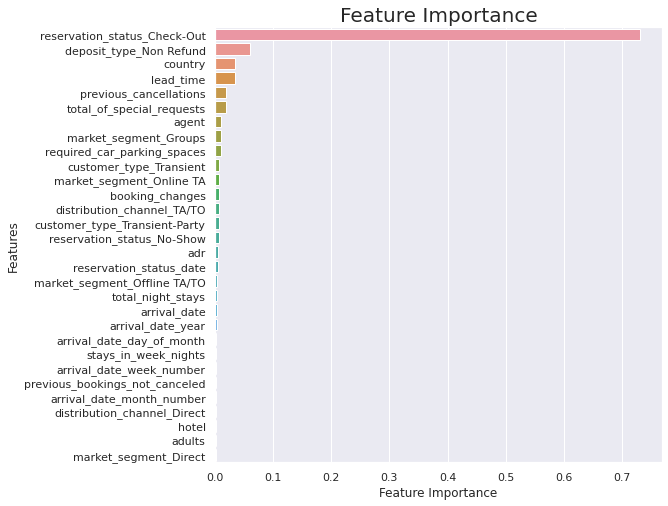

In [ ]:
# Feature Importances
feature_importance = rf_clf.feature_importances_
features = X_imp.columns
# Create a dictionary of features and the feature importances
feature_importance_dict = {features[i] : feature_importance[i] for i in range(len(feature_importance))}
feature_importance_df = pd.DataFrame(feature_importance_dict, index=['Feature Importance']).T.reset_index().rename(columns = {'index' : 'Features'})
feature_importance_df = feature_importance_df.sort_values('Feature Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8,8))
sns.barplot(x='Feature Importance', y='Features', data=feature_importance_df)
plt.title("Feature Importance", fontdict={'fontsize' : 20})
plt.show()

In [ ]:
hotel_booking_data['reservation_status'].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

In [ ]:
# Drop the reservation_status_Check_Out column
X_imp_2 = X_imp.drop("reservation_status_Check-Out", axis=1)

In [ ]:
# Build models again
results_2 = build_models(X_imp_2, y)

########################################### FUNCTION BEGINS #####################################################################
Model Building begins at 2022-11-18 10:20:41.359619
Logistic Regression Model begins
Logistic Regression Model built
Total time taken for Logistic Regression model to build: 3.983 seconds
KNN Model begins
KNN Model built
Total time taken for KNN model to build: 146.678 seconds
Decision Tree Model begins
Decision Tree Model built
Total time taken for Decision Tree model to build: 2.271 seconds
SVM Model begins
SVM Model built
Total time taken for SVM model to build: 846.273 seconds
Random Forest Model begins
Random Forest Model built
Total time taken for Random Forest model to build: 32.668 seconds
Extra Trees Model begins
Extra Trees Model built
Total time taken for Extra Trees model to build: 24.964 seconds
AdaBoost Model begins
AdaBoost Model built
Total time taken for AdaBoost model to build: 12.063 seconds
XGB Model begins
XGB Model built
Total time take

In [ ]:
# Sort the results in descending order
results_2_sorted = results_2.sort_values('Mean CV Accuracy', ascending=False)
results_2_sorted

,Mean CV Accuracy
AdaBoost,0.709683
XGB,0.702018
Logistic Regression,0.698475
LGBM,0.695242
Random Forest,0.684396
Decision Tree,0.640983
KNN,0.605269
Extra Trees,0.599414
SVM,0.582896


In [ ]:
# Split the data into train and test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_imp_2, y, test_size=0.2, random_state=42)

In [ ]:
# 1. Light GBM

lgbm_clf = LGBMClassifier() # Default Model

# Set up hyperparameters
num_leaves = [31, 51, 71, 91, 111, 200, 500]
max_depth = [-1, 50, 100, 150, 200, 300, 500]
learning_rate = [0.01, 0.05, 0.1, 0.5]
reg_alpha = [0.0, 0.25, 0.5, 0.75, 1.0]
reg_lambda = [0.0, 0.5, 1.0]

lgbm_params = {"num_leaves" : num_leaves,
               "max_depth" : max_depth,
               "learning_rate" : learning_rate,
               "reg_alpha" : reg_alpha,
               "reg_lambda" : reg_lambda
               }

# Using RandomizedSearchCV for hyperparameter tuning
rscv_lgbm = RandomizedSearchCV(lgbm_clf, lgbm_params, n_iter=10, scoring='accuracy', n_jobs=-1, cv=3, random_state=12, verbose=4)
rscv_lgbm.fit(X_train_2, y_train_2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                                        'max_depth': [-1, 50, 100, 150, 200,
                                                      300, 500],
                                        'num_leaves': [31, 51, 71, 91, 111, 200,
                                                       500],
                                        'reg_alpha': [0.0, 0.25, 0.5, 0.75,
                                                      1.0],
                                        'reg_lambda': [0.0, 0.5, 1.0]},
                   random_state=12, scoring='accuracy', verbose=4)

In [ ]:
# Print the mean cv scores calculated
mean_cv_0 = np.mean(rscv_lgbm.cv_results_["split0_test_score"])
mean_cv_1 = np.mean(rscv_lgbm.cv_results_["split1_test_score"])
mean_cv_2 = np.mean(rscv_lgbm.cv_results_["split2_test_score"])

print("Cross Validation Accuracy Scores for Tuned Light GBM Classifer are:")
for i in range(3):
  print("Split {} Score: ".format(i+1), np.round(100*np.mean(rscv_lgbm.cv_results_["split{}_test_score".format(i)]),2), '%')

Cross Validation Accuracy Scores for Tuned Light GBM Classifer are:
Split 1 Score:  90.86 %
Split 2 Score:  90.81 %
Split 3 Score:  91.0 %


In [ ]:
# Test the model on the test set
test_acc_score_2 = rscv_lgbm.score(X_test_2, y_test_2)
print("Accuracy of Light Gradient Bossting Model (Tuned) on the test set is {:.2f}%".format(test_acc_score_2*100))

Accuracy of Light Gradient Bossting Model (Tuned) on the test set is 97.83%


In [ ]:
# Store the probabilities as well
prediction_prob = rscv_lgbm.predict_proba(X_test_2)

In [ ]:
# Extract the best estimator and train it on the entire dataset and then dump the model in a pickle file
lgbm_clf_best = rscv_lgbm.best_estimator_

# fit the model
lgbm_clf_best.fit(X_imp_2, y)

LGBMClassifier(max_depth=150, num_leaves=200, reg_alpha=0.5, reg_lambda=0.5)

In [ ]:
# Dump the model
file_path = "./LightGBM_Classifier.pkl"
pickle_out = open(file_path, "wb")
pickle.dump(lgbm_clf_best, pickle_out)
pickle_out.close()